In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs, Distributions

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


#### First Things First - *KL Divergence*
I need some space to toy around with calculating the $KL$-divergence and creating mixture distributions before I can create the model.

This turned out to be super easy, since a function already existed :)

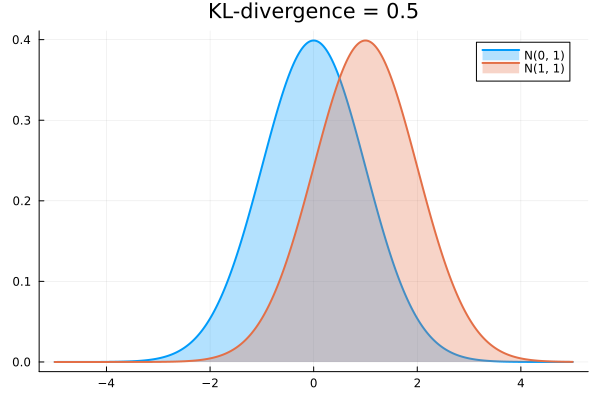

In [2]:
# Calculating the KL-divergence
d1 = Normal(0, 1)
d2 = Normal(1, 1)

kl = kldivergence(d1, d2)

# Plotting the two distributions
x = range(-5, 5, length=1000)
p = plot(x, pdf.(d1, x), label="N(0, 1)", lw=2, fillalpha=0.3, fillrange=0, title="KL-divergence = "*string(kl))
p = plot!(x, pdf.(d2, x), label="N(1, 1)", lw=2, fillalpha=0.3, fillrange=0)
display(p)

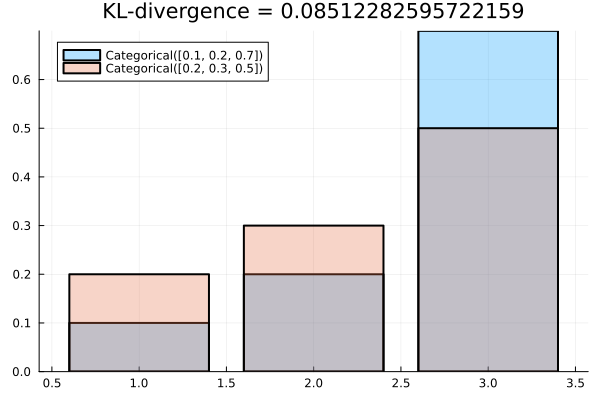

In [3]:
# With the foresight of maybe at some 
# point wanting to calculate the KL-divergence
# between two categorical distributions, lets see
# how that would work

d1 = Categorical([0.1, 0.2, 0.7])
d2 = Categorical([0.2, 0.3, 0.5])

kl = kldivergence(d1, d2)

# Plotting the two distributions
x = 1:3
p = bar(x, pdf.(d1, x), label="Categorical([0.1, 0.2, 0.7])", lw=2, fillalpha=0.3, fillrange=0, title="KL-divergence = "*string(kl))
p = bar!(x, pdf.(d2, x), label="Categorical([0.2, 0.3, 0.5])", lw=2, fillalpha=0.3, fillrange=0)
display(p)

# Cool!! It works. Almost a shame, would have like to 
# implement it myself.

#### On to the Next - *Mixtures*
The second thing to worry about is to how to work with mixtures. I want to start with simply creating and plotting a mixture distribution and then perhaps construct a simple inference model wich utilized a mixture model.

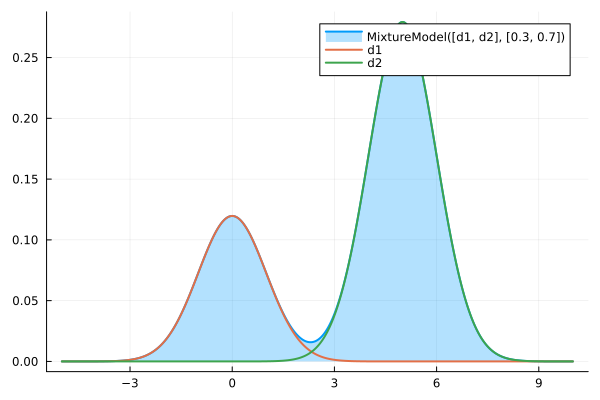

In [4]:
# Creating a mixture model
d1 = Normal(0, 1)
d2 = Normal(5, 1)
d3 = MixtureModel([d1, d2], [0.3, 0.7])

# Plotting the mixture model
x = range(-5, 10, length=1000)
p = plot(x, pdf.(d3, x), label="MixtureModel([d1, d2], [0.3, 0.7])", lw=2, fillalpha=0.3, fillrange=0)
p = plot!(x, 0.3*pdf.(d1, x), label="d1", lw=2)
p = plot!(x, 0.7*pdf.(d2, x), label="d2", lw=2)
display(p)

Alright, that was surprisingly easy. Now lets toy aroudn with an inference setting. 

Lets see if I can recreate the mixture example given on the RxInfer page about inferencing the bias of a coin. Lets start with a Offline case

In [5]:
theta = 0.6
rng   = StableRNG(1234)

function generate_data(rng, N)
  y = rand(rng, Bernoulli(theta), N)
  return y
end

N = 20
y_data = generate_data(rng, N)
println(y_data)

Bool[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
# Defining the model
@model function model(y)
  theta_john ~ Beta(2, 7)
  theta_jane ~ Beta(7, 2)

  johns_right ~ Bernoulli(0.7)

  theta_mixed ~ Mixture(switch=johns_right, inputs=[theta_john, theta_jane])

  y .~ Bernoulli(theta_mixed)
end

results = infer(
  model         = model(),
  data          = (y=y_data,),
  addons        = AddonLogScale(),
  postprocess   = UnpackMarginalPostprocess(),
  returnvars    = (theta_mixed = KeepLast(), johns_right = KeepLast(), theta_john = KeepLast(), theta_jane = KeepLast()),
)

Inference results:
  Posteriors       | available for (theta_mixed, johns_right, theta_jane, theta_john)


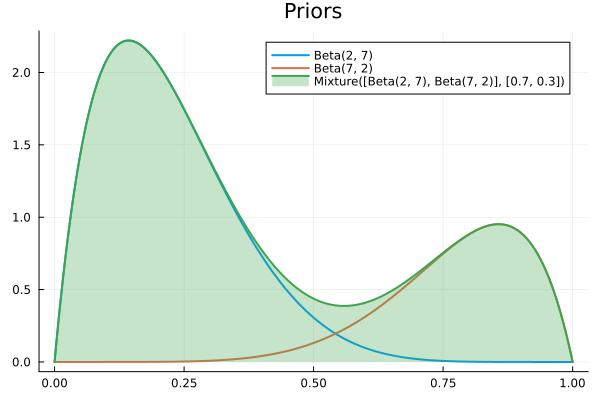

In [7]:
# Plotting the priors
r = range(0, 1, length=1000)
p = plot(r, 0.7*pdf.(Beta(2, 7), r), label="Beta(2, 7)", lw=2, title="Priors")
p = plot!(r, 0.3*pdf.(Beta(7, 2), r), label="Beta(7, 2)", lw=2)
p = plot!(r, pdf.(MixtureModel([Beta(2, 7), Beta(7, 2)], [0.7, 0.3]), r), label="Mixture([Beta(2, 7), Beta(7, 2)], [0.7, 0.3])", lw=2, fillalpha=0.3, fillrange=0)
display(p)

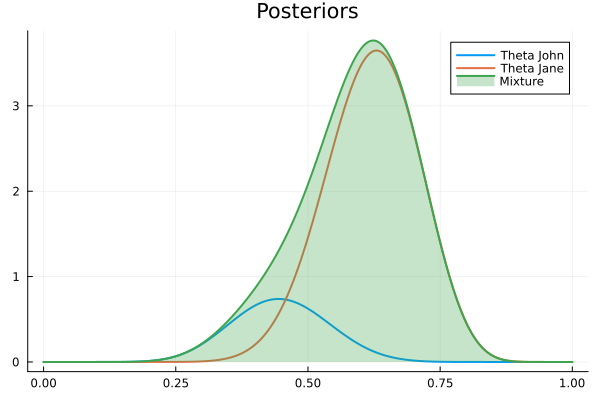

Johns right: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.17217391304347782, 0.8278260869565223])
Mean of the Mixture: 0.5910044977511245
Mean of John: 0.4482758620689655
Mean of Jane: 0.6206896551724138


In [8]:
# Plotting the posteriors
r = range(0, 1, length=1000)
p = plot(title="Posteriors")
p = plot!(r, (x) -> results.posteriors[:theta_mixed].weights[1]*pdf(component(results.posteriors[:theta_mixed], 1), x), label="Theta John", lw=2)
p = plot!(r, (x) -> results.posteriors[:theta_mixed].weights[2]*pdf(component(results.posteriors[:theta_mixed], 2), x), label="Theta Jane", lw=2)
p = plot!(r, (x) -> pdf(results.posteriors[:theta_mixed], x), label="Mixture", lw=2, fillalpha=0.3, fillrange=0)
display(p)

# Printing some variables
println("Johns right: ", results.posteriors[:johns_right])
println("Mean of the Mixture: ", mean(results.posteriors[:theta_mixed]))
println("Mean of John: ", mean(results.posteriors[:theta_john]))
println("Mean of Jane: ", mean(results.posteriors[:theta_jane]))

#### Cool - *Bring it Online*
Okay, so the previous section was again not that hard. Lets try and change is to a Online model and see if things stay nice and neat.

In [9]:
theta = 0.5
rng   = StableRNG(1234)

datastream   = Subject(Bool)
observations = labeled(Val((:y, )), combineLatest(datastream))

function generate_data(rng)
  y = rand(rng, Bernoulli(theta))
  return y
end

generate_data (generic function with 2 methods)

In [10]:
# Testing the datastream
test_subscribtion = subscribe!(observations, (data) -> println(data))

for i in 1:5
  data = generate_data(rng)
  next!(datastream, data)
end

unsubscribe!(test_subscribtion)

(y = false,)
(y = false,)
(y = false,)
(y = false,)
(y = true,)


In [11]:
# Defining the model
@model function model(_johns_right, jo_a, jo_b, ja_a, ja_b, y)
  john_theta ~ Beta(a=jo_a, b=jo_b)
  jane_theta ~ Beta(a=ja_a, b=ja_b)

  johns_right ~ Categorical(_johns_right)

  mixed_theta ~ Mixture(switch=johns_right, inputs=[john_theta, jane_theta])

  y ~ Bernoulli(mixed_theta)
end

model_autoupdates = @autoupdates begin
  _johns_right = params(q(johns_right))
  jo_a, jo_b = params(q(john_theta))
  ja_a, ja_b = params(q(jane_theta))
end

@autoupdates begin
    _johns_right = params(q(johns_right))
    (jo_a, jo_b) = params(q(john_theta))
    (ja_a, ja_b) = params(q(jane_theta))
end


In [12]:
# initialization and inferencing
imarginal = @initialization begin
  johns_right = Categorical([0.5, 0.5])
  john_theta  = Beta(2, 7)
  jane_theta  = Beta(7, 2)
  #mixed_theta = MixtureModel([john_theta, jane_theta], [0.5, 0.5])
end

ireturnvars = (
  mixed_theta = KeepLast(),
)

engine = infer(
  model           = model(),
  constraints     = MeanField(),
  datastream      = observations,
  autoupdates     = model_autoupdates,
  initialization  = imarginal,
  iterations      = 10,
  keephistory     = 100,
  historyvars     = ireturnvars,
  autostart       = false,
  free_energy     = true,
  addons          = AddonLogScale(),
  postprocess     = UnpackMarginalPostprocess(),
)

MethodError: MethodError: no method matching getlocalclusters(::MixtureNode{2})
The function `getlocalclusters` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  getlocalclusters(!Matched::ReactiveMP.StandaloneDistributionNode)
   @ ReactiveMP ~/.julia/packages/ReactiveMP/cZQEH/src/nodes/predefined/distribution/distribution.jl:14
  getlocalclusters(!Matched::FactorNode)
   @ ReactiveMP ~/.julia/packages/ReactiveMP/cZQEH/src/nodes/nodes.jl:201


#### EHMM - *Gausian Mixture*
That seems not to be working due to an issue I'm unable to resolve. Lets see if I can obtain some online inference results using Gausian mixtures

In [38]:
rng   = StableRNG(1234)

datastream   = Subject(Float64)
observations = labeled(Val((:y, )), combineLatest(datastream))

position, noise = 1, 0.1

function generate_data(rng, x, v)
  noise = rand(rng, Normal(0, v))
  y = x + noise
  return y
end

generate_data (generic function with 3 methods)

In [39]:
# Testing the datastream
test_subscribtion = subscribe!(observations, (data) -> println(data))

for i in 1:5
  data = generate_data(rng, position, noise)
  next!(datastream, data)
end

unsubscribe!(test_subscribtion)


(y = 1.051949454850376,)
(y = 1.0905139726861126,)
(y = 0.8324338842090443,)
(y = 0.8705266555587259,)
(y = 0.9315634529141368,)


In [40]:
# Defining the model
@model function model(y, _t, _m1_u, _m1_v, _w1_s, _w1_r, _m2_u, _m2_v, _w2_s, _w2_r)
  sw ~ Bernoulli(_t)

  m[1] ~ Normal(mean = _m1_u, variance = _m1_v)
  w[1] ~ Gamma(shape = _w1_s, rate = _w1_r)

  m[2] ~ Normal(mean = _m2_u, variance = _m2_v)
  w[2] ~ Gamma(shape = _w2_s, rate = _w2_r)

  y ~ NormalMixture(switch=sw, m=m, p=w)
end

model_autoupdates = @autoupdates begin
  _t = params(q(sw))
  _m1_u, _m1_v = params(q(m[1]))
  #_w1_s, _w1_r = params(q(w[1]))
  _m2_u, _m2_v = params(q(m[2]))
  #_w2_s, _w2_r = params(q(w[2]))
end

@autoupdates begin
    _t = params(q(sw))
    (_m1_u, _m1_v) = params(q(m[1]))
    (_m2_u, _m2_v) = params(q(m[2]))
end


In [41]:
imarginals = @initialization begin
  q(sw) = vague(Bernoulli)
  q(m) = [NormalMeanVariance(-2.0, 1e3), NormalMeanVariance(2.0, 1e3)]
  q(w) = [vague(GammaShapeRate), vague(GammaShapeRate)]
  #q(m) = [Normal(0, 1), Normal(1, 1)]
  #q(w) = [Gamma(1, 1), Gamma(1, 1)]
end

ireturnvars = (
  sw = KeepLast(),
  m = KeepLast(),
  w = KeepLast(),
)

engine = infer(
  model           = model(),
  constraints     = MeanField(),
  datastream      = observations,
  autoupdates     = model_autoupdates,
  initialization  = imarginals,
  #iterations      = 10,
  keephistory     = 100,
  historyvars     = ireturnvars,
  autostart       = false,
  free_energy     = true,
  addons          = AddonLogScale(),
  postprocess     = UnpackMarginalPostprocess(),
)

ErrorException: Missing interface _johns_right

In [42]:
# Start the engine
RxInfer.start(engine)

# Generate some data
for i in 1:100
  data = generate_data(rng, position, noise)
  next!(datastream, data)
end


┌ Warning: The engine is already running. Cannot start a single engine twice.
└ @ RxInfer /root/.julia/packages/RxInfer/052ft/src/inference/streaming.jl:189


In [18]:
# Stop the engine
RxInfer.stop(engine)